In [1]:
import sys
import os
import json
import matplotlib.pyplot as plt
import numpy as np

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, TextStreamer
from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config

parent_path = os.path.dirname(os.getcwd())
target_dir = f'{parent_path}/lightcode'
sys.path.append(target_dir)

# import Relay_compiler
import graph_visualization as gv
import hardware as hw
import graph_transformations as gt
import stacked_graph as sg
import testing as test
import data_collection as dc
from main import forward


/home/rjtomich/miniconda3/envs/schedule/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Regular Inference (gpt2)

In [11]:
def generate_token(model_name, prompt):
    # model = AutoModelForCausalLM.from_pretrained(model_name, torchscript=True)
    # tokenizer = AutoTokenizer.from_pretrained(model_name)

    model = GPT2LMHeadModel.from_pretrained("gpt2")
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

    tokenizer.pad_token = tokenizer.eos_token
    streamer = TextStreamer(tokenizer)

    model.tie_weights()

    inputs = tokenizer(prompt, return_tensors="pt", padding=True)
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]



    model = model.eval()  # Change to eval mode

    # gen_tokens = model.generate(input_ids, do_sample=False, max_new_tokens=10, streamer=streamer)
    gen_tokens = model.generate(
                                    input_ids,
                                    attention_mask=attention_mask,
                                    do_sample=False,
                                    max_length=15,
                                    pad_token_id=tokenizer.pad_token_id,
                                    streamer=streamer
                                )

    gen_text = tokenizer.decode(gen_tokens[0], skip_special_tokens=True)

    return input_ids, gen_tokens, gen_text
    return int(gen_tokens[0][-1])

model_name = 'gpt2'
prompt = "my favorite music is"

prompt_tokens, gen_tokens, gen_text = generate_token(model_name, prompt)
print(f'{"Prompt Tokens:":<20} {prompt_tokens}')
print(f'{"Generated Tokens:":<20} {gen_tokens}')

my favorite music is "The Last of Us" by the Grateful Dead.
Prompt Tokens:       tensor([[1820, 4004, 2647,  318]])
Generated Tokens:    tensor([[ 1820,  4004,  2647,   318,   366,   464,  4586,   286,  4021,     1,
           416,   262, 44249,  5542,    13]])


# Export the model to TVM Relay IR

Precomputed to save time (takes about 1 minuet for gpt2)

In [3]:
# model_onnx, input_ids = transformer_torch_to_onnx(model_name, prompt, save=False)
# lib = onnx_to_relay(model_onnx, input_ids, write=True, model_name=model_name, opt_level=0)

# Visualize computational Graph
Computational graph visualization for one token generation

In [1]:
relay_path = "../lightcode/models/Llama-2-7b-hf_graph.json"

CPU_MAX_CLOCK = 5.0875 * 10**9
CPU_AVERAGE_CLOCK = 3.208 * 10**9
PHU_MIN_CLOCK = 10 * 10**9 #100**9, 10 Ghz

hardware = []
hw.Hardware._hardware_reset()
# hardware.append(hw.CPU(CPU_MAX_CLOCK, 1))
hardware.append(hw.CPU(CPU_AVERAGE_CLOCK, 1))
# hardware.append(hw.PHU(PHU_MIN_CLOCK, 1, 20))

available_hardware = hw.initilize_hardware(hardware)

optimization = 'time'
# optimization = 'energy'

with open(relay_path, encoding="utf-8") as json_file:
    raw_json = json.load(json_file)  # returns json file as dict

WEIGHT_VARIABLE = optimization
graph = sg.StackGraph(raw_json=raw_json, weight_variable=WEIGHT_VARIABLE)
gv.adj_to_graph(graph, ax=1, layout='spectral', title=f'Subgraph', stack=True)

# kk ,spectral, shell, spring


NameError: name 'hw' is not defined

# Optimizations
1) Subdevide
2) Stack
3) select

# Create Simulation Enviroment

In [2]:
relay_path = "../lightcode/models/Llama-2-7b-hf_graph.json"

CPU_MAX_CLOCK = 5.0875 * 10**9
CPU_AVERAGE_CLOCK = 3.208 * 10**9
PHU_MIN_CLOCK = 10 * 10**9 #100**9, 10 Ghz

hardware = []
hw.Hardware._hardware_reset()
# hardware.append(hw.CPU(CPU_MAX_CLOCK, 1))
hardware.append(hw.CPU(CPU_AVERAGE_CLOCK, 1))
# hardware.append(hw.PHU(PHU_MIN_CLOCK, 1, 20))

available_hardware = hw.initilize_hardware(hardware)

optimization = 'time'
# optimization = 'energy'

In [3]:
def draw_subgraphs(subgraphs, sub = False):
    if isinstance(subgraphs, list):
        for g in subgraphs:
            fig, ax = plt.subplots(figsize=(5, 5))
            gv.adj_to_graph(g, ax=ax, stack=True, layout='kk', title=f'Subgraph')
            # plt.tight_layout()
            plt.show()

    else:
        fig, ax = plt.subplots(figsize=(5, 5))
        gv.adj_to_graph(subgraphs, ax=ax, stack=True, layout='kk', title=f'Subgraph')
        # plt.tight_layout()
        plt.show()


subgraph_to_plot = 3

with open(relay_path, encoding="utf-8") as json_file:
    raw_json = json.load(json_file)  # returns json file as dict

WEIGHT_VARIABLE = optimization
graph = sg.StackGraph(raw_json=raw_json, weight_variable=WEIGHT_VARIABLE)
print('graph')
stacked_subgraphs = list(gt.graph_partition(graph, weight_variable=WEIGHT_VARIABLE))
print(f'stacked_subgraphs: {len(stacked_subgraphs)}')
flat_subgraphs = gt.select_nodes(
    stacked_subgraphs, weight_variable=WEIGHT_VARIABLE
)
# print('flat_subgraphs')
# expanded_flat_subgraphs = gt.expand_nodes(flat_subgraphs)

# print(f' 2 / {len(stacked_subgraphs)}')
# draw_subgraphs(stacked_subgraphs[1])


graph
stacked_subgraphs: 49
0
3.117206982543641e-10
9.567747298420614e-10
2.0220475023547677e-07
2.0284980426706446e-07
0
0
3.117206982543641e-10
3.117206982543641e-10
9.567747298420614e-10
9.567747298420614e-10
1.6108925998415211e-06
3.2208284249532e-06
4.830764250064879e-06
7.66213798836243e-06
7.66213798836243e-06
9.272073813474108e-06
9.272073813474108e-06
1.0882009638585787e-05
1.0882009638585787e-05
1.5323319201995018e-05
1.5323964256026607e-05
1.532518952618454e-05
1.552772760975335e-05
1.5529931267276212e-05
1.6933255027106694e-05
1.6933900081138283e-05
1.693512535129622e-05
1.713766343486503e-05
1.713986709238789e-05
1.8543190852218376e-05
1.8543835906249965e-05
1.85450611764079e-05
1.874759925997671e-05
1.874980291749957e-05
2.31911124809088e-05
2.4801048306020478e-05
2.6410984131132157e-05
3.0852293694541386e-05
3.085293874857297e-05
3.246222951965307e-05
3.2462874573684654e-05
3.4072165344764744e-05
3.407281039879633e-05
0.006907241916359032
0.006907241916359032
0.006907241

KeyboardInterrupt: 

# MAC's in GP2 Inference

In [20]:
scheduled_flat_graph, end_time, break_points = dijk.schdeule_nodes(
    graph, expanded_flat_subgraphs, available_hardware
)
time_profile = dc.get_time_profile(scheduled_flat_graph)
energy_profile = dc.get_energy_per_opp(scheduled_flat_graph)
print(time_profile)
print(energy_profile)

{'where': 2.555282555282555e-09, 'add': 7.457718496906434e-05, 'less': 1.9656019656019657e-10, 'nop': 4.0687960687960835e-08, 'split': 2.6333333333333424e-08, 'dot_prod_phu': 0.0024907776000005232, 'mean': 3.0230958230958245e-05, 'transpose': 5.072196560196567e-05, 'divide': 4.52874692874693e-07, 'multiply': 0.0001461275675675676, 'softmax': 2.717248157248158e-06, 'subtract': 1.509582309582309e-05, 'rsqrt': 1.9656019656019646e-08, 'take': 1.9656019656019657e-10, 'power': 4.4079803439803446e-05, 'tanh': 0.00011593592137592141, 'get_dram': 0.0}
{'where': 1.2999999999999999e-11, 'add': 1.4799999999999977e-10, 'less': 1e-12, 'nop': 2.0699999999999957e-10, 'split': 1.5799999999999974e-10, 'dot_prod_phu': 9.963110400007527e-07, 'mean': 5.000000000000006e-11, 'transpose': 8.4e-11, 'divide': 1.1999999999999999e-11, 'multiply': 9.799999999999995e-11, 'softmax': 1.1999999999999999e-11, 'subtract': 2.4999999999999998e-11, 'rsqrt': 2.4999999999999998e-11, 'take': 1e-12, 'power': 3.700000000000002e

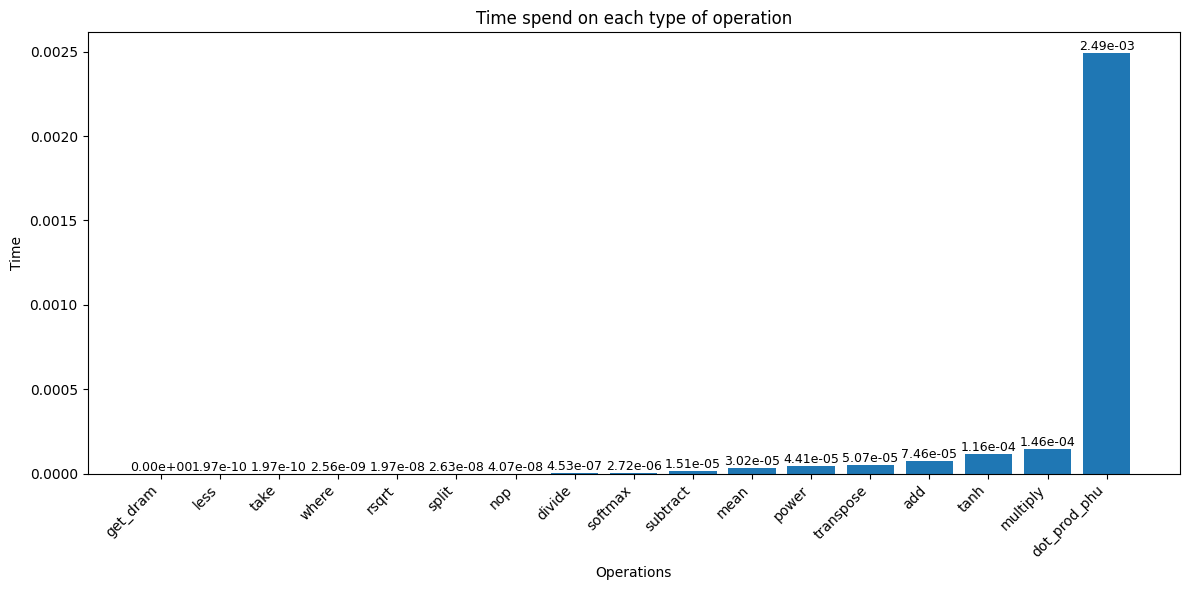

In [21]:
time_profile_sorted = dict(sorted(time_profile.items(), key=lambda item: item[1]))
energy_profile_sorted = dict(sorted(energy_profile.items(), key=lambda item: item[1]))


labels = list(time_profile_sorted.keys())
values = list(time_profile_sorted.values())

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(labels, values)

ax.set_xlabel('Operations')
ax.set_ylabel('Time')
ax.set_title('Time spend on each type of operation')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2e}', va='bottom', ha='center', fontsize=9)

# Show plot
plt.tight_layout()
plt.show()


# End to End

In [25]:
relay_path = "gpt2_graph.json"

CPU_MAX_CLOCK = 5.0875 * 10**9
CPU_AVERAGE_CLOCK = 3.208 * 10**9
PHU_MIN_CLOCK = 10 * 10**9 #100**9, 10 Ghz

hardware = []
hw.Hardware._hardware_reset()
hardware.append(hw.CPU(CPU_MAX_CLOCK, 1))
# hardware.append(hw.CPU(CPU_AVERAGE_CLOCK, 1))
hardware.append(hw.PHU(PHU_MIN_CLOCK, 1, 20))

available_hardware = hw.initilize_hardware(hardware)

optimization = 'time'
# optimization = 'energy'

forward(
    relay_path,
    optimization,
    available_hardware,
    profiles=True,
    get_step_times=False,
    data_collection=False,
)


---------- INFO ----------
WEIGHT_VARIABLE='time'
Photonic Selected: 73 / 73
{'task_para_matmul_phu', 'dot_prod_phu', 'get_dram', 'task_para_dense_phu', 'start'}
Makespan: 0.00328 s
Number of Nodes: 30817
Net DRAM: -162016264 bits
Net SRAM: 0 bits
Total Energy Consumption: 50520722175.8 pico-joules
time_distrabution {'where': 2.555282555282555e-09, 'add': 7.457718496906434e-05, 'less': 1.9656019656019657e-10, 'nop': 4.0687960687960835e-08, 'split': 2.6333333333333424e-08, 'dot_prod_phu': 0.0024907776000005232, 'mean': 3.0230958230958245e-05, 'transpose': 5.072196560196567e-05, 'divide': 4.52874692874693e-07, 'multiply': 0.0001461275675675676, 'softmax': 2.717248157248158e-06, 'subtract': 1.509582309582309e-05, 'rsqrt': 1.9656019656019646e-08, 'take': 1.9656019656019657e-10, 'power': 4.4079803439803446e-05, 'tanh': 0.00011593592137592141, 'get_dram': 0.0} compute seconds 
---------- ---- ----------
